In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt

np.random.seed(42)

## Funciones

In [2]:
class OptionPayoff:
    def __init__(self) -> None:
        pass

    @staticmethod
    def long_call_payoff(st, k, premium):
        return np.maximum(st - k, 0) - premium
    
    @staticmethod
    def short_call_payoff(st, k, premium):
        return premium - np.maximum(st - k, 0)
    
    @staticmethod
    def long_put_payoff(st, k, premium):
        return np.maximum(k - st, 0) - premium
    
    @staticmethod
    def short_put_payoff(st, k, premium):
        return premium - np.maximum(k - st, 0)

In [3]:
def straddle_payoff(st, k, premium_call, premium_put):
    return np.maximum(st - k, 0) - premium_call + np.maximum(k - st, 0) - premium_put

def simulate_price(mu: int | float, sigma: int | float, last_price: int | float, n_sims: int, n_days: int) -> np.ndarray:
    """
    mu y sigma diarios
    """
    Z = np.random.normal(size=(n_sims, n_days))
    returns = mu + sigma * Z
    cumulative_returns = (returns + 1).cumprod(axis=1)
    return last_price * cumulative_returns

def black_scholes_price(S: float, K: int | float, T: int | float, r: float, sigma: float, option_type: str = 'call') -> float:
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2)* T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        
    return price

def american_option_price(So: float, K: int | float , T: int | float, rf: float, sigma: float, n: int, option_type: str = 'call'):
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    disc = np.exp(-rf * dt)
    p = (np.exp(rf * dt) - d) / (u - d)

    # Generar todos los precios posibles del subyacente en el último paso
    j = np.arange(n + 1)
    ST = So * (u ** (n - j)) * (d ** j)

    # Valor terminal de la opción
    if option_type == 'put':
        option_values = np.maximum(K - ST, 0.0)
    else:
        option_values = np.maximum(ST - K, 0.0)

    # Backward induction
    for i in range(n - 1, -1, -1):
        ST = ST[:-1] / u  # precios del subyacente en el paso anterior
        option_values = disc * (p * option_values[:-1] + (1 - p) * option_values[1:])

        # Valor por ejercicio anticipado
        if option_type == 'put':
            exercise = np.maximum(K - ST, 0.0)
        else:
            exercise = np.maximum(ST - K, 0.0)

        option_values = np.maximum(option_values, exercise)

    return option_values[0]

def plot_simulations(sim_prices):
    plt.figure(figsize=(10, 6))
    plt.plot(sim_prices.T)
    plt.title('Simulated Price Paths')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.show()

In [4]:
option = OptionPayoff()

## Precios

In [4]:
tickers = ['AAPL']
start_date = '2020-01-01'
end_date = '2025-04-14'

data = yf.download(tickers, start_date, end_date, progress=False)['Close']

rt = data.pct_change().dropna()

mu = rt.mean().values
sigma = rt.std().values
last_price = data.iloc[-1].values

YF.download() has changed argument auto_adjust default to True


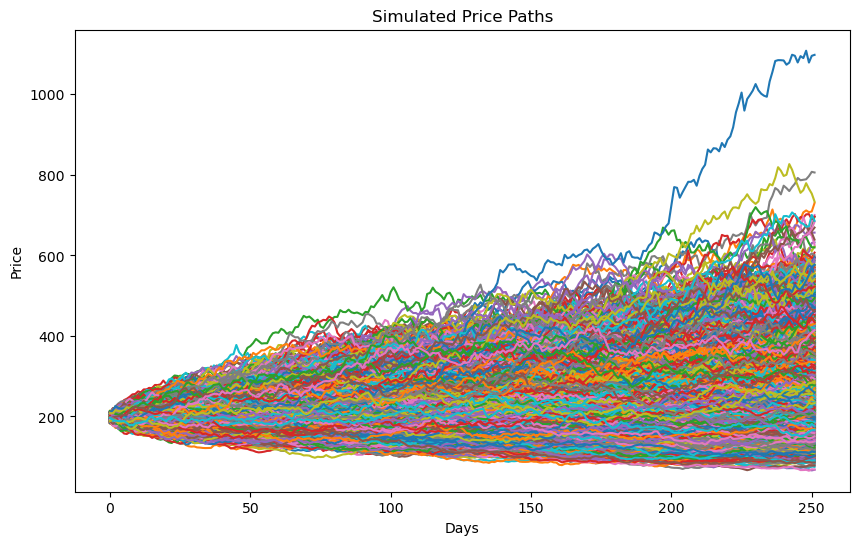

In [5]:
prices = simulate_price(mu, sigma, last_price, 100_000, 252)
plot_simulations(prices[0:10_000, :])

## Straddle

In [6]:
rows = 1000
st = np.linspace(100,300, rows)

In [7]:
strikes = np.array([190])

premiums_long_calls = american_option_price(last_price, 190, 1, 0.04, sigma*np.sqrt(252), 10_000, 'call')
premiums_long_puts = american_option_price(last_price, 190, 1, 0.04, sigma*np.sqrt(252), 10_000, 'put')

long_calls = option.long_call_payoff(st[:, None], strikes, premiums_long_calls)
long_puts = option.long_put_payoff(st[:, None], strikes, premiums_long_puts)

strat_payoff = straddle_payoff(st[:, None], strikes, premiums_long_calls, premiums_long_puts)

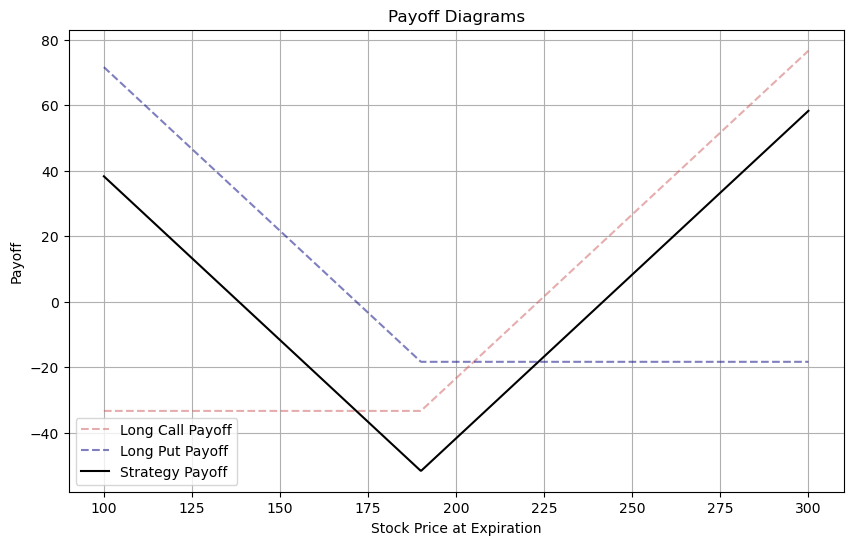

In [8]:
plt.figure(figsize=(10, 6))

plt.plot(st, long_calls, label='Long Call Payoff', linestyle='--', color='indianred', alpha = 0.5)
plt.plot(st, long_puts, label='Long Put Payoff', linestyle='--', color='navy', alpha = 0.5)
plt.plot(st, strat_payoff, label='Strategy Payoff', color='black') 

plt.title('Payoff Diagrams')
plt.xlabel('Stock Price at Expiration')
plt.ylabel('Payoff')
plt.legend()
plt.grid()
plt.show()

## Using a class

In [81]:
class Straddle:
    def __init__(self, ticker: str, start_date: str, end_date: str, strikes: list[int | float], n_sims: int = 100_000) -> None:
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.strikes = strikes
        self.n_sims = n_sims

        self.data = yf.download(self.ticker, self.start_date, self.end_date, progress=False)['Close']
        self.rt = self.data.pct_change().dropna()
        self.mu = self.rt.mean().values
        self.sigma = self.rt.std().values
        self.last_price = self.data.iloc[-1].values

    def simulate_price(self) -> np.ndarray:
        """
        mu y sigma diarios
        """
        Z = np.random.normal(size=(self.n_sims, 252))
        returns = self.mu + self.sigma * Z
        cumulative_returns = (returns + 1).cumprod(axis=1)
        return self.last_price * cumulative_returns  
    
    def straddle_payoff(self, st: np.ndarray, k: int | float, premium_call: float, premium_put: float) -> np.ndarray:
        return np.maximum(st - k, 0) - premium_call + np.maximum(k - st, 0) - premium_put
    
    def american_option_price(self, So: float, K: int | float , T: int | float, rf: float, sigma: float, n: int, option_type: str = 'call') -> float:
        dt = T / n
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        disc = np.exp(-rf * dt)
        p = (np.exp(rf * dt) - d) / (u - d)

        # Generar todos los precios posibles del subyacente en el último paso
        j = np.arange(n + 1)
        ST = So * (u ** (n - j)) * (d ** j)

        # Valor terminal de la opción
        if option_type == 'put':
            option_values = np.maximum(K - ST, 0.0)
        else:
            option_values = np.maximum(ST - K, 0.0)

        # Backward induction
        for i in range(n - 1, -1, -1):
            ST = ST[:-1] / u  # precios del subyacente en el paso anterior
            option_values = disc * (p * option_values[:-1] + (1 - p) * option_values[1:])

            # Valor por ejercicio anticipado
            if option_type == 'put':
                exercise = np.maximum(K - ST, 0.0)
            else:
                exercise = np.maximum(ST - K, 0.0)

            option_values = np.maximum(option_values, exercise)

        return option_values[0]
        
    def plot_simulations(self, sim_prices: np.ndarray) -> None:
        plt.figure(figsize=(10, 6))
        plt.plot(sim_prices.T)
        plt.title('Simulated Price Paths')
        plt.xlabel('Days')
        plt.ylabel('Price')
        plt.show()

    def plot_payoff(self, strikes: list[int | float]) -> np.ndarray:
        rows = 1000
        st = np.linspace(100, 300, rows)

        premiums_long_calls = american_option_price(self.last_price, strikes[0], 1, 0.04, self.sigma * np.sqrt(252), 10_000, 'call')
        premiums_long_puts = american_option_price(self.last_price, strikes[0], 1, 0.04, self.sigma * np.sqrt(252), 10_000, 'put')

        long_calls = option.long_call_payoff(st[:, None], strikes[0], premiums_long_calls)
        long_puts = option.long_put_payoff(st[:, None], strikes[0], premiums_long_puts)

        strat_payoff =  long_calls + long_puts
    
        plt.figure(figsize=(10, 6))
        plt.plot(st, long_calls, label='Long Call Payoff', linestyle='--', color='indianred', alpha=0.5)
        plt.plot(st, long_puts, label='Long Put Payoff', linestyle='--', color='navy', alpha=0.5)
        plt.plot(st, strat_payoff, label='Straddle Payoff', color='black')

        plt.title('Payoff Diagrams')
        plt.xlabel('Stock Price at Expiration')
        plt.ylabel('Payoff')
        plt.legend()
        plt.grid()
        plt.show()

    def execute(self) -> None:
        np.random.seed(42)
        sim_prices = self.simulate_price()
        last_prices_sim = sim_prices[:, -1]

        self.plot_simulations(sim_prices[0:10_000, :])
        self.plot_payoff(self.strikes)
        
        premiums_long_calls = self.american_option_price(self.last_price, self.strikes[0], 1, 0.04, self.sigma * np.sqrt(252), 10_000, 'call')
        premiums_long_puts = self.american_option_price(self.last_price, self.strikes[0], 1, 0.04, self.sigma * np.sqrt(252), 10_000, 'put')
        profits = straddle_payoff(last_prices_sim, self.strikes[0], premiums_long_calls, premiums_long_puts)

        expected_profit = np.mean(profits)
        cost = premiums_long_calls + premiums_long_puts
        pct_profit = expected_profit / cost
        conf_interval = [np.percentile(profits, 2.5), np.percentile(profits, 97.5)]

        print(f'El profit esperado es de ${expected_profit:.2f}')
        print(f'El rendimiento esperado de la estrategia es de {pct_profit:.2%}')
        print(f'El intervalo de confianza del 95% para el profit es de {conf_interval}')

In [82]:
strategy = Straddle('AAPL', '2020-01-01', '2025-04-14', [190])

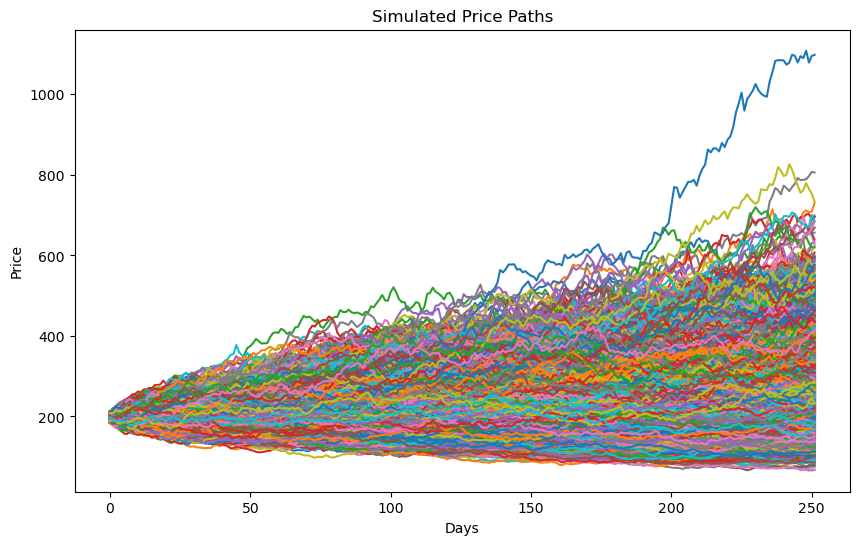

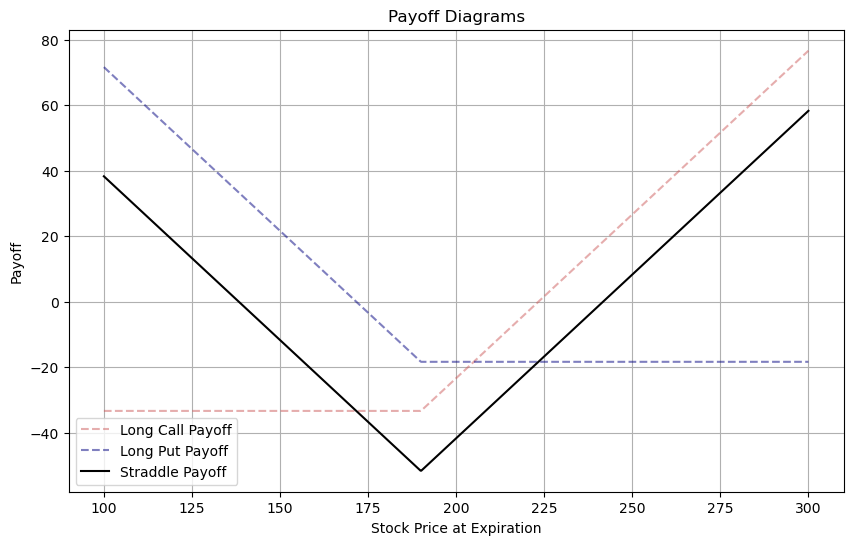

El profit esperado es de $26.06
El rendimiento esperado de la estrategia es de 50.40%
El intervalo de confianza del 95% para el profit es de [-49.213304520028046, 211.851785476351]


In [83]:
strategy.execute()

In [89]:
class MultiStraddle:
    def __init__(self, tickers, start_date, end_date, strikes, n_sims=100_000):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.strikes = strikes
        self.n_sims = n_sims
        self.option = OptionPayoff()

        self.data = yf.download(self.tickers, self.start_date, self.end_date, progress=False)['Close'][self.tickers]
        self.rt = self.data.pct_change().dropna()
        self.mu = self.rt.mean().values
        self.sigma = self.rt.std().values
        self.anual_sigma = self.sigma * np.sqrt(252)
        self.last_price = self.data.iloc[-1].values

    def simulate_price(self, mu, sigma, last_price):
        Z = np.random.normal(size=(self.n_sims, 252))
        returns = mu + sigma * Z
        cumulative_returns = (returns + 1).cumprod(axis=1)
        return last_price * cumulative_returns

    def american_option_price(self, So, K, T, rf, sigma, n, option_type='call'):
        dt = T / n
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        disc = np.exp(-rf * dt)
        p = (np.exp(rf * dt) - d) / (u - d)
        j = np.arange(n + 1)
        ST = So * (u ** (n - j)) * (d ** j)

        option_values = np.maximum(K - ST, 0.0) if option_type == 'put' else np.maximum(ST - K, 0.0)

        for i in range(n - 1, -1, -1):
            ST = ST[:-1] / u
            option_values = disc * (p * option_values[:-1] + (1 - p) * option_values[1:])
            exercise = np.maximum(K - ST, 0.0) if option_type == 'put' else np.maximum(ST - K, 0.0)
            option_values = np.maximum(option_values, exercise)

        return option_values[0]

    def straddle_payoff(self, st, k, premium_call, premium_put):
        return np.maximum(st - k, 0) - premium_call + np.maximum(k - st, 0) - premium_put

    def plot_simulations(self, prices, ticker):
        plt.figure(figsize=(8, 4))
        plt.plot(prices[:5000, :].T)
        plt.title(f'Simulated Price Paths for {ticker}')
        plt.xlabel('Days')
        plt.ylabel('Price')
        plt.show()

    def plot_payoffs(self, st, long_calls, long_puts, strat_payoff, ticker):
        plt.figure(figsize=(10, 6))
        plt.plot(st, long_calls, label='Long Call Payoff', linestyle='--', color='indianred', alpha=0.5)
        plt.plot(st, long_puts, label='Long Put Payoff', linestyle='--', color='navy', alpha=0.5)
        plt.plot(st, strat_payoff, label='Strategy Payoff', color='black')
        plt.title(f'Payoff Diagrams {ticker}')
        plt.xlabel('Stock Price at Expiration')
        plt.ylabel('Payoff')
        plt.legend()
        plt.grid()
        plt.show()

    def execute(self, periods=[20, 62, 125, 251]):
        rows = 10_000
        st = np.linspace(0, 800, rows)

        for i, ticker in enumerate(self.tickers):
            prices = self.simulate_price(self.mu[i], self.sigma[i], self.last_price[i])
            self.plot_simulations(prices, ticker)

            k = self.strikes[i]
            premium_call = self.american_option_price(self.last_price[i], k, 1, 0.04, self.anual_sigma[i], 10_000, 'call')
            premium_put = self.american_option_price(self.last_price[i], k, 1, 0.04, self.anual_sigma[i], 10_000, 'put')

            long_call = self.option.long_call_payoff(st[:, None], k, premium_call)
            long_put = self.option.long_put_payoff(st[:, None], k, premium_put)
            strat_payoff = self.straddle_payoff(st[:, None], k, premium_call, premium_put)

            self.plot_payoffs(st, long_call, long_put, strat_payoff, ticker)

            for p in periods:
                final_prices = prices[:, p]
                profits = self.straddle_payoff(final_prices, k, premium_call, premium_put)
                expected_profit = np.mean(profits)
                cost = premium_call + premium_put
                pct_profit = expected_profit / cost
                conf_interval = [np.percentile(profits, 2.5), np.percentile(profits, 97.5)]

                print(f'Para {ticker}:')
                print(f'Las ganancias esperadas ejerciendo las opciones a los {p+1} días son:')
                print(f'El profit esperado es de ${expected_profit:.2f}')
                print(f'El rendimiento esperado de la estrategia es de {pct_profit:.2%}')
                print(f'El intervalo de confianza del 95% para el profit es de {conf_interval}')
                print()


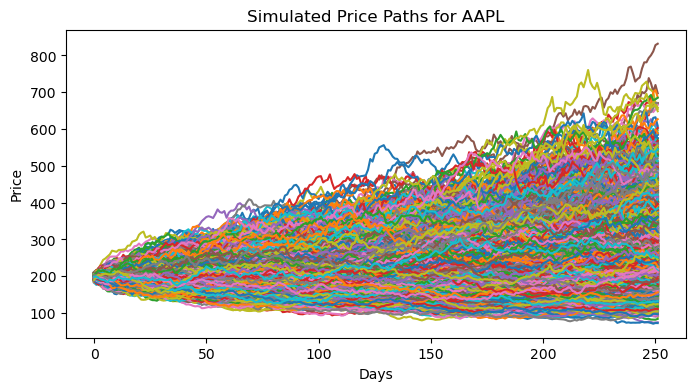

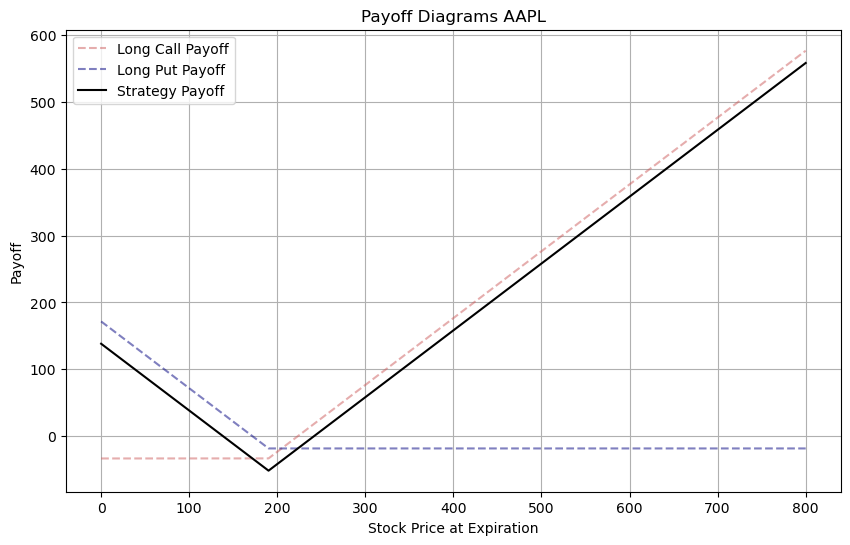

Para AAPL:
Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $-33.73
El rendimiento esperado de la estrategia es de -65.24%
El intervalo de confianza del 95% para el profit es de [-50.988603979277215, 0.6356941711782709]

Para AAPL:
Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $-20.43
El rendimiento esperado de la estrategia es de -39.51%
El intervalo de confianza del 95% para el profit es de [-50.58168467042212, 44.883140499960305]

Para AAPL:
Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $-4.39
El rendimiento esperado de la estrategia es de -8.49%
El intervalo de confianza del 95% para el profit es de [-50.05113660462537, 100.52290473579566]

Para AAPL:
Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $26.23
El rendimiento esperado de la estrategia es de 50.73%
El intervalo de confianza del 95% para el prof

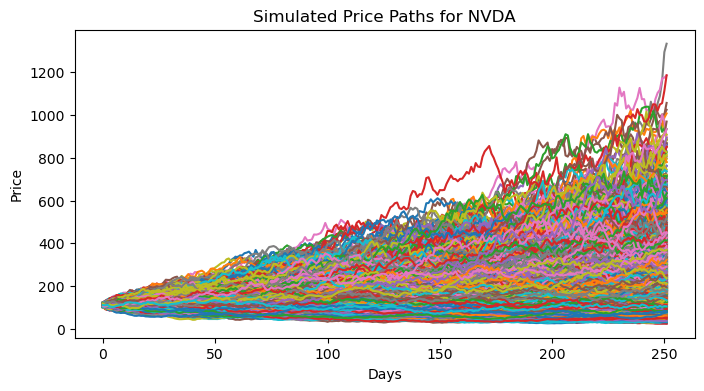

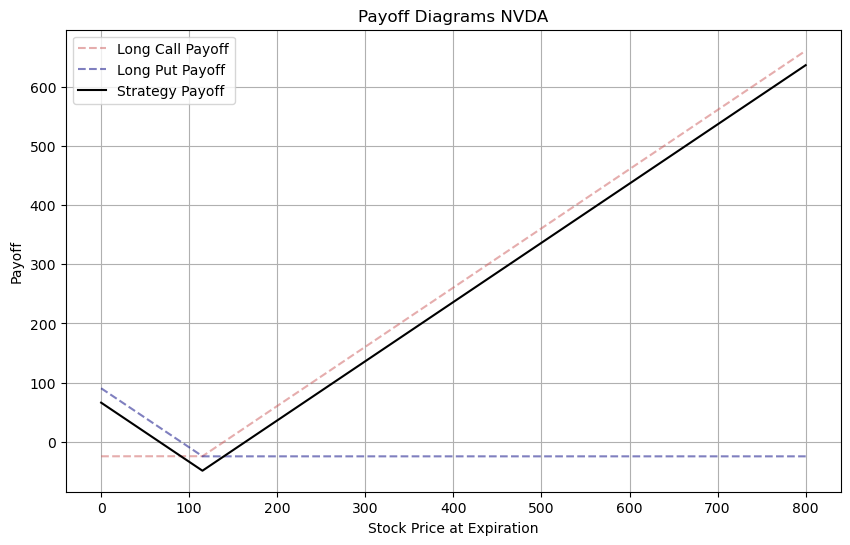

Para NVDA:
Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $-33.78
El rendimiento esperado de la estrategia es de -69.32%
El intervalo de confianza del 95% para el profit es de [-48.1464912669175, -4.839919149368386]

Para NVDA:
Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $-18.08
El rendimiento esperado de la estrategia es de -37.10%
El intervalo de confianza del 95% para el profit es de [-47.644689095289685, 54.98868496517038]

Para NVDA:
Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $6.54
El rendimiento esperado de la estrategia es de 13.41%
El intervalo de confianza del 95% para el profit es de [-47.06989671974337, 151.41693021311463]

Para NVDA:
Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $70.41
El rendimiento esperado de la estrategia es de 144.49%
El intervalo de confianza del 95% para el profit

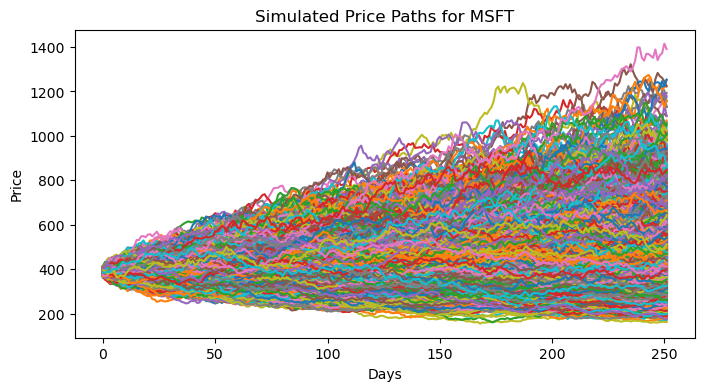

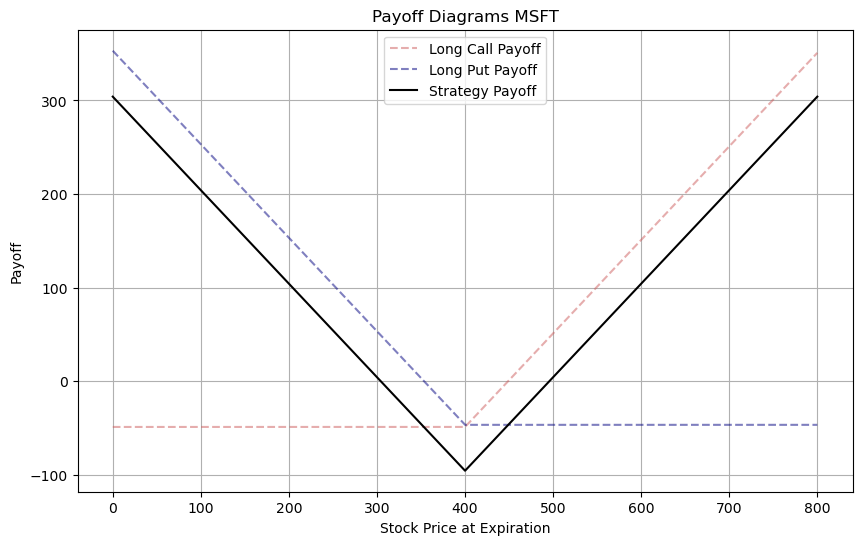

Para MSFT:
Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $-67.79
El rendimiento esperado de la estrategia es de -70.66%
El intervalo de confianza del 95% para el profit es de [-94.80962983662488, -17.67750665658634]

Para MSFT:
Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $-45.91
El rendimiento esperado de la estrategia es de -47.85%
El intervalo de confianza del 95% para el profit es de [-93.9626295309002, 52.11786831627307]

Para MSFT:
Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $-19.13
El rendimiento esperado de la estrategia es de -19.94%
El intervalo de confianza del 95% para el profit es de [-93.09895586143813, 152.03261233400065]

Para MSFT:
Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $32.19
El rendimiento esperado de la estrategia es de 33.56%
El intervalo de confianza del 95% para el profi

In [90]:
MultiStraddle(['AAPL', 'NVDA', 'MSFT'], '2020-01-01', '2025-04-14', [190, 115, 400]).execute()

## Probability of Winning

In [9]:
union = pd.DataFrame({
    'st': st,
    'strat_payoff': strat_payoff[:, 0],
})

mask = union['strat_payoff'] <= 0
indices = union.index[mask]

lower_idx = indices.min() - 1
upper_idx = indices.max() + 1

lower_value = union.loc[lower_idx, 'st']
upper_value = union.loc[upper_idx, 'st']        

In [10]:
last_prices_sim = prices[:, -1]
lower_probability = np.mean(last_prices_sim < lower_value) 
upper_probability = np.mean(last_prices_sim > upper_value)

print(f'La probabilidad de ganar si el precio baja es: {lower_probability:.2%}')
print(f'La probabilidad de ganar si el precio sube es: {upper_probability:.2%}')

print(f'La probabilidad de ganar con el straddle es de {lower_probability + upper_probability:.2%}')

La probabilidad de ganar si el precio baja es: 4.71%
La probabilidad de ganar si el precio sube es: 48.98%
La probabilidad de ganar con el straddle es de 53.69%


## Expected Value

In [11]:
profits = straddle_payoff(last_prices_sim, strikes, premiums_long_calls, premiums_long_puts)

expected_profit = np.mean(profits)
cost = premiums_long_calls + premiums_long_puts
pct_profit = expected_profit / cost
conf_interval = [np.percentile(profits, 2.5), np.percentile(profits, 97.5)]


print(f'El profit esperado es de ${expected_profit:.2f}')
print(f'El rendimiento esperado de la estrategia es de {pct_profit:.2%}')
print(f'El intervalo de confianza del 95% para el profit es de {conf_interval}')

El profit esperado es de $26.06
El rendimiento esperado de la estrategia es de 50.40%
El intervalo de confianza del 95% para el profit es de [-49.213303848940726, 211.85174470531538]


## Loops

In [12]:
union = pd.DataFrame({
    'st': st,
    'strat_payoff': strat_payoff[:, 0],
})

mask = union['strat_payoff'] <= 0
indices = union.index[mask]

lower_idx = indices.min() - 1
upper_idx = indices.max() + 1

lower_value = union.loc[lower_idx, 'st']
upper_value = union.loc[upper_idx, 'st']

periods = [20, 62, 125, 251]
time_prices = [prices[:, i] for i in periods]

In [13]:
for i in range(len(periods)):
    lower_probability = np.mean(time_prices[i] < lower_value) 
    upper_probability = np.mean(time_prices[i] > upper_value)

    print(f'Probabilidades a los {periods[i]+1} días:')
    print(f'La probabilidad de ganar si el precio baja es: {lower_probability:.2%}')
    print(f'La probabilidad de ganar si el precio sube es: {upper_probability:.2%}')
    print(f'La probabilidad de ganar con el straddle es de {lower_probability + upper_probability:.2%}')
    print()

Probabilidades a los 21 días:
La probabilidad de ganar si el precio baja es: 0.00%
La probabilidad de ganar si el precio sube es: 2.56%
La probabilidad de ganar con el straddle es de 2.56%

Probabilidades a los 63 días:
La probabilidad de ganar si el precio baja es: 0.67%
La probabilidad de ganar si el precio sube es: 17.79%
La probabilidad de ganar con el straddle es de 18.46%

Probabilidades a los 126 días:
La probabilidad de ganar si el precio baja es: 2.54%
La probabilidad de ganar si el precio sube es: 32.65%
La probabilidad de ganar con el straddle es de 35.18%

Probabilidades a los 252 días:
La probabilidad de ganar si el precio baja es: 4.71%
La probabilidad de ganar si el precio sube es: 48.98%
La probabilidad de ganar con el straddle es de 53.69%



In [14]:
for i in range(len(periods)):

    profits = straddle_payoff(time_prices[i], strikes, premiums_long_calls, premiums_long_puts)

    expected_profit = np.mean(profits)
    cost = premiums_long_calls + premiums_long_puts
    pct_profit = expected_profit / cost
    conf_interval = [np.percentile(profits, 2.5), np.percentile(profits, 97.5)]

    print(f'Las ganancias esperadas ejerciendo las opciones a los {periods[i]+1} días son:')
    print(f'El profit esperado es de ${expected_profit:.2f}')
    print(f'El rendimiento esperado de la estrategia es de {pct_profit:.2%}')
    print(f'El intervalo de confianza del 95% para el profit es de {conf_interval}')
    print()

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $-33.82
El rendimiento esperado de la estrategia es de -65.42%
El intervalo de confianza del 95% para el profit es de [-51.021851128027286, 0.2676559450883598]

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $-20.52
El rendimiento esperado de la estrategia es de -39.69%
El intervalo de confianza del 95% para el profit es de [-50.56485599767773, 44.38905702580541]

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $-4.47
El rendimiento esperado de la estrategia es de -8.64%
El intervalo de confianza del 95% para el profit es de [-50.01244603001721, 101.12372980229594]

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $26.06
El rendimiento esperado de la estrategia es de 50.40%
El intervalo de confianza del 95% para el profit es de [-49.213303848940726, 211.8517447053

## For n assets

### Prices

In [15]:
tickers = ['AAPL', 'NVDA', 'MSFT']
start_date = '2020-01-01'
end_date = '2025-04-14'

data = yf.download(tickers, start_date, end_date, progress=False)['Close'][tickers]

rt = data.pct_change().dropna()

mu = rt.mean().values
sigma = rt.std().values
anual_sigma = sigma * np.sqrt(252)
last_price = data.iloc[-1].values

In [16]:
prices = [simulate_price(mu[i], sigma[i], last_price[i], 100_000, 252) for i in range(len(tickers))]

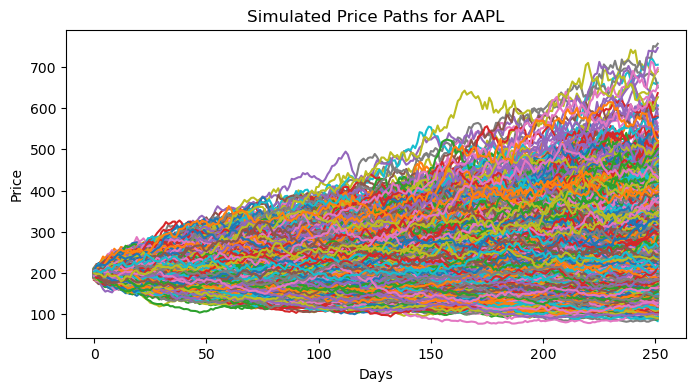

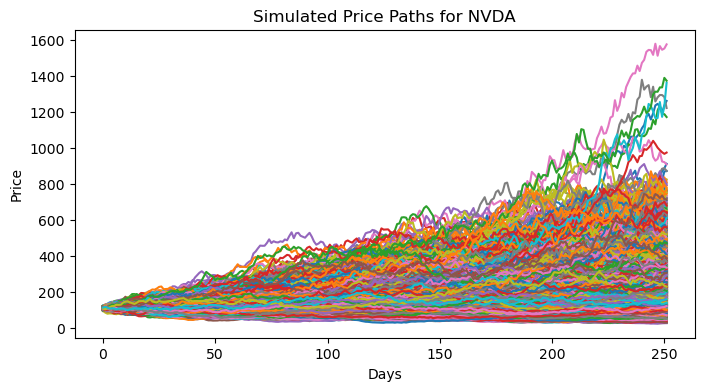

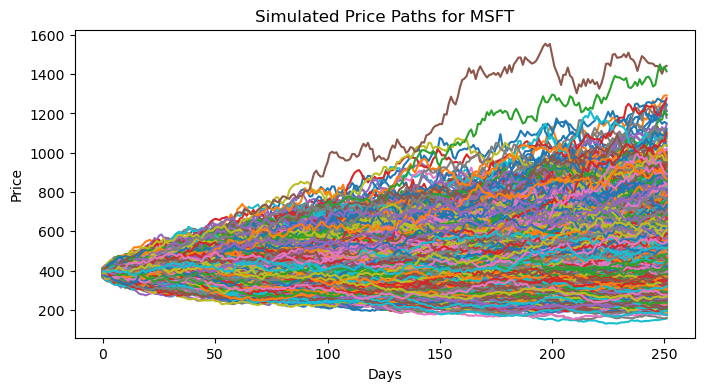

In [17]:
for i in range(len(tickers)):
    plt.figure(figsize=(8, 4))
    plt.plot(prices[i][0:5000, :].T)
    plt.title(f'Simulated Price Paths for {tickers[i]}')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.show()

### Straddle

In [18]:
rows = 10_000
st = np.linspace(0,800, rows)
strikes = [190, 115, 400]

In [19]:
premiums_long_calls = [american_option_price(last_price[i], strikes[i], 1, 0.04, anual_sigma[i], 10_000, 'call') for i in range(len(tickers))]
premiums_long_puts = [american_option_price(last_price[i], strikes[i], 1, 0.04, anual_sigma[i], 10_000, 'put') for i in range(len(tickers))]

long_calls = [option.long_call_payoff(st[:, None], strikes[i], premiums_long_calls[i]) for i in range(len(tickers))]
long_puts = [option.long_put_payoff(st[:, None], strikes[i], premiums_long_puts[i]) for i in range(len(tickers))]

strat_payoff = [straddle_payoff(st[:, None], strikes[i], premiums_long_calls[i], premiums_long_puts[i]) for i in range(len(tickers))]

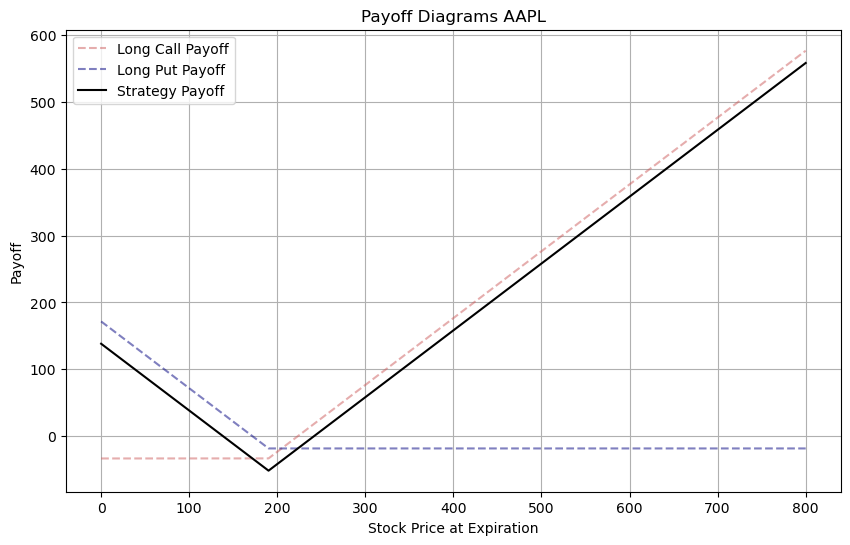

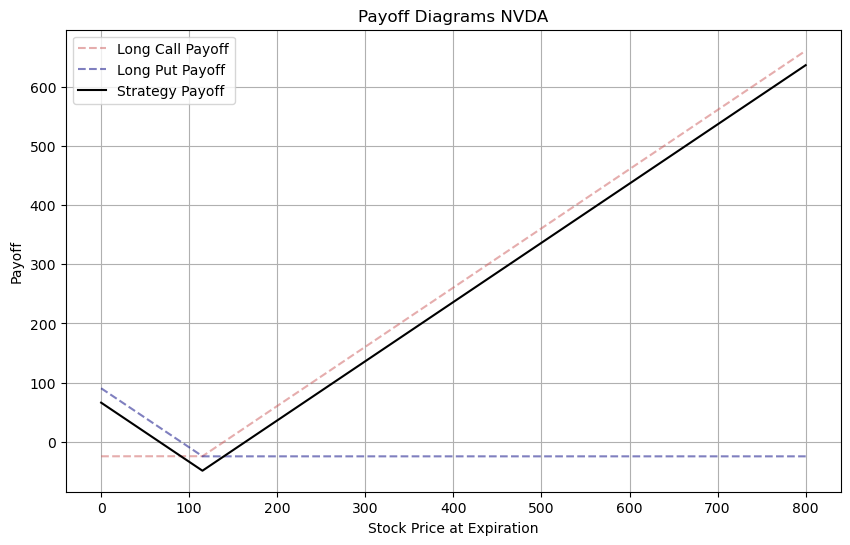

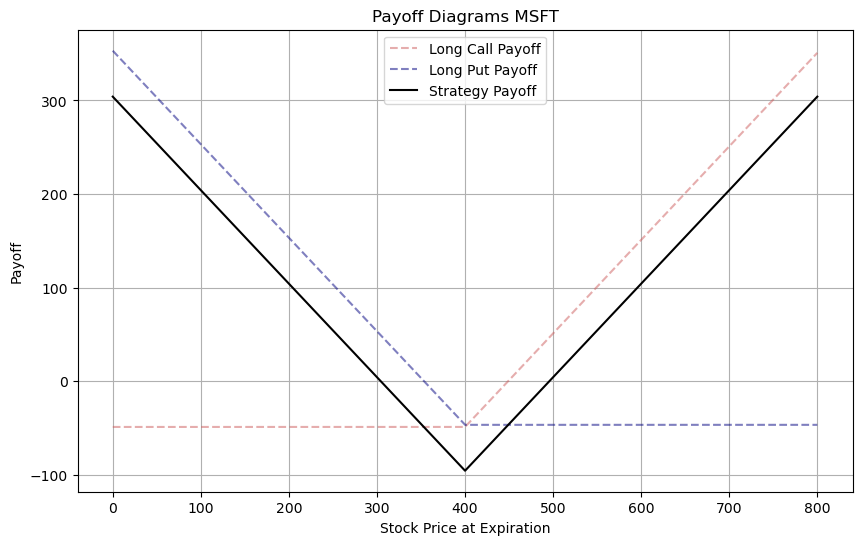

In [20]:
for i in range(len(tickers)):

    plt.figure(figsize=(10, 6))

    plt.plot(st, long_calls[i], label='Long Call Payoff', linestyle='--', color='indianred', alpha = 0.5)
    plt.plot(st, long_puts[i], label='Long Put Payoff', linestyle='--', color='navy', alpha = 0.5)
    plt.plot(st, strat_payoff[i], label='Strategy Payoff', color='black') 

    plt.title(f'Payoff Diagrams {tickers[i]}')
    plt.xlabel('Stock Price at Expiration')
    plt.ylabel('Payoff')
    plt.legend()
    plt.grid()
    plt.show()

### Probability of Winning

In [21]:
periods = [20, 62, 125, 251]
time_prices = [[ticker_prices[:, i] for i in periods] for ticker_prices in prices]

In [22]:
union = pd.DataFrame({
    'st': st
})

for i in range(len(tickers)):
    union[f'strat_payoff_{i}'] = strat_payoff[i][:, 0]

In [23]:
mask = [union[union.columns[i]] <= 0 for i in range(1, len(union.columns))]
indices = [union.index[mask[i]] for i in range(len(mask))]

lower_idx = [indices[i].min() - 1 for i in range(len(indices))]
upper_idx = [indices[i].max() + 1 for i in range(len(indices))]

lower_value = [union.loc[lower_idx[i], 'st'] for i in range(len(lower_idx))]
upper_value = [union.loc[upper_idx[i], 'st'] for i in range(len(upper_idx))]

In [24]:
for j in range(len(tickers)):
    print(f'Para {tickers[j]}:')
    for i in range(len(periods)):
        lower_probability = np.mean(time_prices[j][i] < lower_value[j]) 
        upper_probability = np.mean(time_prices[j][i] > upper_value[j])

        print(f'Probabilidades a los {periods[i]+1} días:')
        print(f'La probabilidad de ganar si el precio baja es: {lower_probability:.2%}')
        print(f'La probabilidad de ganar si el precio sube es: {upper_probability:.2%}')
        print(f'La probabilidad de ganar con el straddle es de {lower_probability + upper_probability:.2%}')
        print()

Para AAPL:
Probabilidades a los 21 días:
La probabilidad de ganar si el precio baja es: 0.00%
La probabilidad de ganar si el precio sube es: 2.75%
La probabilidad de ganar con el straddle es de 2.75%

Probabilidades a los 63 días:
La probabilidad de ganar si el precio baja es: 0.68%
La probabilidad de ganar si el precio sube es: 17.69%
La probabilidad de ganar con el straddle es de 18.37%

Probabilidades a los 126 días:
La probabilidad de ganar si el precio baja es: 2.56%
La probabilidad de ganar si el precio sube es: 32.45%
La probabilidad de ganar con el straddle es de 35.01%

Probabilidades a los 252 días:
La probabilidad de ganar si el precio baja es: 4.69%
La probabilidad de ganar si el precio sube es: 48.90%
La probabilidad de ganar con el straddle es de 53.59%

Para NVDA:
Probabilidades a los 21 días:
La probabilidad de ganar si el precio baja es: 0.02%
La probabilidad de ganar si el precio sube es: 1.51%
La probabilidad de ganar con el straddle es de 1.53%

Probabilidades a los

### Expected Value

In [25]:
for j in range(len(tickers)):
    print(f'Para {tickers[j]}:')
    for i in range(len(periods)):

        profits = straddle_payoff(time_prices[j][i], strikes[j], premiums_long_calls[j], premiums_long_puts[j])

        expected_profit = np.mean(profits)
        cost = premiums_long_calls[j] + premiums_long_puts[j]
        pct_profit = expected_profit / cost
        conf_interval = [np.percentile(profits, 2.5), np.percentile(profits, 97.5)]

        print(f'Las ganancias esperadas ejerciendo las opciones a los {periods[i]+1} días son:')
        print(f'El profit esperado es de ${expected_profit:.2f}')
        print(f'El rendimiento esperado de la estrategia es de {pct_profit:.2%}')
        print(f'El intervalo de confianza del 95% para el profit es de {conf_interval}')
        print()

Para AAPL:
Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $-33.76
El rendimiento esperado de la estrategia es de -65.30%
El intervalo de confianza del 95% para el profit es de [-51.04014801606072, 1.071394001684634]

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $-20.64
El rendimiento esperado de la estrategia es de -39.92%
El intervalo de confianza del 95% para el profit es de [-50.61941413985465, 44.519361905485695]

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $-4.51
El rendimiento esperado de la estrategia es de -8.73%
El intervalo de confianza del 95% para el profit es de [-50.043356680944186, 100.9829628661175]

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $25.93
El rendimiento esperado de la estrategia es de 50.16%
El intervalo de confianza del 95% para el profit es de [-49.271936749060664, 212.